# Introduction to Ray

## References
* Walkthrough of material from: https://github.com/ray-project/tutorial/blob/master/rllib_exercises/rllib_exercise02_ppo.ipynb

## Pre install steps
* Start a jupyter notebook on linux/mac. I will pip packages into a fresh conda environment. Preferred method:
```conda create --name ray_ece python=3.7 pip jupyter```

* Use docker with the same sort of environment.
* **SOON**: jupyterhub environment!

# Install Ray and RLlib

Install ray using ipynb/jupyter **magic** `!`

In [1]:
# Be sure to install the latest version of RLlib and sundry requirements
! pip install -U ray[rllib]
! pip install requests pandas aiohttp psutil setproctitle grpcio tensorflow

Requirement already up-to-date: ray[rllib] in /home/jhineman/.conda/envs/ray_ece/lib/python3.7/site-packages (0.8.1)


In [2]:
# view dependencies
! pip list | grep tensorflow

tensorflow             2.1.0              
tensorflow-estimator   2.1.0              


Import the basic pieces for ray/rllib. We will look at PPO applied to a gym environment.

In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import gym
import ray
from ray.rllib.agents.ppo import PPOTrainer, DEFAULT_CONFIG
from ray.tune.logger import pretty_print

## Initialize ray
* We explore a simple local configuration
* Many configurations for distributed computation available: https://ray.readthedocs.io/en/latest/package-ref.html#ray.init

In [4]:
# Start ray locally (there are lots of configurations)
ray.init(num_cpus=4, ignore_reinit_error=True, log_to_driver=False)

2020-02-19 09:11:14,670	WARNING services.py:592 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-02-19 09:11:14,673	INFO resource_spec.py:212 -- Starting Ray with 4.74 GiB memory available for workers and up to 2.37 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-02-19 09:11:15,083	INFO services.py:1093 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '172.28.46.114',
 'redis_address': '172.28.46.114:11550',
 'object_store_address': '/tmp/ray/session_2020-02-19_09-11-14_660583_1683/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-02-19_09-11-14_660583_1683/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-02-19_09-11-14_660583_1683'}

## Running RLlib PPO on cartpole

### Config and patterns used in RLlib
* RLlib uses a functional pattern where as much of configuration as possible is pushed to data (possibly data gathered at runtime).
* Read more about this approach: https://bair.berkeley.edu/blog/2019/10/14/functional-rl/
* Here we explore the base configuration some

In [5]:
config = DEFAULT_CONFIG.copy() # just a dictionary that has been imported and copied
print(config)

{'num_workers': 2, 'num_envs_per_worker': 1, 'sample_batch_size': 200, 'batch_mode': 'truncate_episodes', 'num_gpus': 0, 'train_batch_size': 4000, 'model': {'conv_filters': None, 'conv_activation': 'relu', 'fcnet_activation': 'tanh', 'fcnet_hiddens': [256, 256], 'free_log_std': False, 'no_final_linear': False, 'vf_share_layers': True, 'use_lstm': False, 'max_seq_len': 20, 'lstm_cell_size': 256, 'lstm_use_prev_action_reward': False, 'state_shape': None, 'framestack': True, 'dim': 84, 'grayscale': False, 'zero_mean': True, 'custom_preprocessor': None, 'custom_model': None, 'custom_action_dist': None, 'custom_options': {}}, 'optimizer': {}, 'gamma': 0.99, 'horizon': None, 'soft_horizon': False, 'no_done_at_end': False, 'env_config': {}, 'env': None, 'normalize_actions': False, 'clip_rewards': None, 'clip_actions': True, 'preprocessor_pref': 'deepmind', 'lr': 5e-05, 'monitor': False, 'log_level': 'WARN', 'callbacks': {'on_episode_start': None, 'on_episode_step': None, 'on_episode_end': Non

In [6]:
# change values at particular keys (note this could all come from yaml or json)
config['num_workers'] = 1
config['num_sgd_iter'] = 30
config['sgd_minibatch_size'] = 128
config['model']['fcnet_hiddens'] = [100, 100]
config['num_cpus_per_worker'] = 0  # This avoids running out of resources in the notebook environment when this cell is re-executed

agent = PPOTrainer(config, 'CartPole-v0')

2020-02-19 09:15:11,233	INFO trainer.py:370 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-02-19 09:15:11,251	INFO trainer.py:517 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
/home/jhineman/.conda/envs/ray_ece/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
2020-02-19 09:15:13,735	WARNING util.py:41 -- Install gputil for GPU system monitoring.


In [7]:
for i in range(2):
    result = agent.train()
    print(pretty_print(result))

custom_metrics: {}
date: 2020-02-19_09-16-24
done: false
episode_len_mean: 22.07777777777778
episode_reward_max: 64.0
episode_reward_mean: 22.07777777777778
episode_reward_min: 9.0
episodes_this_iter: 180
episodes_total: 180
experiment_id: 9722d609f1f341bfa1ff3a535b0aaf12
hostname: GDA-Oryx-Pro
info:
  grad_time_ms: 1550.989
  learner:
    default_policy:
      cur_kl_coeff: 0.20000000298023224
      cur_lr: 4.999999873689376e-05
      entropy: 0.6645869612693787
      entropy_coeff: 0.0
      kl: 0.029658453539013863
      policy_loss: -0.036578744649887085
      total_loss: 140.36514282226562
      vf_explained_var: 0.044398948550224304
      vf_loss: 140.39576721191406
  load_time_ms: 54.579
  num_steps_sampled: 4000
  num_steps_trained: 3968
  sample_time_ms: 2861.59
  update_time_ms: 417.982
iterations_since_restore: 1
node_ip: 172.28.46.114
num_healthy_workers: 1
off_policy_estimator: {}
perf:
  cpu_util_percent: 10.480392156862745
  ram_util_percent: 55.61960784313726
pid: 1683


In [8]:
# the builder pattern is everywhere ...
agent.env_creator # environment is not stored, a function that creates an environment is

<function ray.rllib.agents.trainer.Trainer._setup.<locals>.<lambda>(env_config)>

In [9]:
env = agent.env_creator({}) # we can sometimes still get what we want ..
print(env)

<TimeLimit<CartPoleEnv<CartPole-v0>>>


/home/jhineman/.conda/envs/ray_ece/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [10]:
print(env.observation_space)
print(env.action_space)
print(env.observation_space.sample())

Box(4,)
Discrete(2)
[-3.7602694e+00  2.2963904e+38 -1.1841742e-01 -2.7519723e+38]


In [11]:
# compute some observation, then ask the agent to compute an action
obs = env.observation_space.sample()
agent.compute_action(obs)

1

### EXERCISE:
Train the agent and try to get a reward of 200. If it's training too slowly you may need to modify the config above to use fewer hidden units, a larger sgd_minibatch_size, a smaller num_sgd_iter, or a larger num_workers.

This should take around 20 or 30 training iterations.

In [12]:
# build out a new config and trainer
config = DEFAULT_CONFIG.copy()
config['num_workers'] = 3
config['num_sgd_iter'] = 30
config['sgd_minibatch_size'] = 128
config['model']['fcnet_hiddens'] = [100, 100]
config['num_cpus_per_worker'] = 0

agent = PPOTrainer(config, 'CartPole-v0')

2020-02-19 09:19:43,772	WARNING util.py:41 -- Install gputil for GPU system monitoring.


In [13]:
## Train for a while
for i in range(20):
    result = agent.train()
    print(pretty_print(result))

custom_metrics: {}
date: 2020-02-19_09-20-31
done: false
episode_len_mean: 20.290816326530614
episode_reward_max: 78.0
episode_reward_mean: 20.290816326530614
episode_reward_min: 8.0
episodes_this_iter: 196
episodes_total: 196
experiment_id: 392844cac8324e449d35d952893d139f
hostname: GDA-Oryx-Pro
info:
  grad_time_ms: 1530.222
  learner:
    default_policy:
      cur_kl_coeff: 0.20000000298023224
      cur_lr: 4.999999873689376e-05
      entropy: 0.6656069159507751
      entropy_coeff: 0.0
      kl: 0.02901650220155716
      policy_loss: -0.037179093807935715
      total_loss: 141.67079162597656
      vf_explained_var: 0.04460170492529869
      vf_loss: 141.70217895507812
  load_time_ms: 49.266
  num_steps_sampled: 4000
  num_steps_trained: 3968
  sample_time_ms: 1186.299
  update_time_ms: 411.536
iterations_since_restore: 1
node_ip: 172.28.46.114
num_healthy_workers: 3
off_policy_estimator: {}
perf:
  cpu_util_percent: 11.279710144927538
  ram_util_percent: 57.08115942028985
pid: 1683

custom_metrics: {}
date: 2020-02-19_09-20-46
done: false
episode_len_mean: 160.51
episode_reward_max: 200.0
episode_reward_mean: 160.51
episode_reward_min: 21.0
episodes_this_iter: 20
episodes_total: 437
experiment_id: 392844cac8324e449d35d952893d139f
hostname: GDA-Oryx-Pro
info:
  grad_time_ms: 1296.304
  learner:
    default_policy:
      cur_kl_coeff: 0.30000001192092896
      cur_lr: 4.999999873689376e-05
      entropy: 0.5432698130607605
      entropy_coeff: 0.0
      kl: 0.0011955982772633433
      policy_loss: -0.002593438373878598
      total_loss: 1009.892333984375
      vf_explained_var: 0.06992652267217636
      vf_loss: 1009.8944702148438
  load_time_ms: 8.168
  num_steps_sampled: 28000
  num_steps_trained: 27776
  sample_time_ms: 1158.207
  update_time_ms: 61.113
iterations_since_restore: 7
node_ip: 172.28.46.114
num_healthy_workers: 3
off_policy_estimator: {}
perf:
  cpu_util_percent: 44.26666666666667
  ram_util_percent: 57.5
pid: 1683
policy_reward_max: {}
policy_reward

custom_metrics: {}
date: 2020-02-19_09-20-59
done: false
episode_len_mean: 192.46
episode_reward_max: 200.0
episode_reward_mean: 192.46
episode_reward_min: 108.0
episodes_this_iter: 20
episodes_total: 562
experiment_id: 392844cac8324e449d35d952893d139f
hostname: GDA-Oryx-Pro
info:
  grad_time_ms: 1252.498
  learner:
    default_policy:
      cur_kl_coeff: 0.03750000149011612
      cur_lr: 4.999999873689376e-05
      entropy: 0.5892895460128784
      entropy_coeff: 0.0
      kl: 0.002546993549913168
      policy_loss: -0.002509665209800005
      total_loss: 478.4742126464844
      vf_explained_var: 0.1929381787776947
      vf_loss: 478.47662353515625
  load_time_ms: 1.267
  num_steps_sampled: 52000
  num_steps_trained: 51584
  sample_time_ms: 1096.567
  update_time_ms: 2.665
iterations_since_restore: 13
node_ip: 172.28.46.114
num_healthy_workers: 3
off_policy_estimator: {}
perf:
  cpu_util_percent: 48.03333333333333
  ram_util_percent: 57.26666666666667
pid: 1683
policy_reward_max: {}
p

custom_metrics: {}
date: 2020-02-19_09-21-13
done: false
episode_len_mean: 197.42
episode_reward_max: 200.0
episode_reward_mean: 197.42
episode_reward_min: 139.0
episodes_this_iter: 20
episodes_total: 687
experiment_id: 392844cac8324e449d35d952893d139f
hostname: GDA-Oryx-Pro
info:
  grad_time_ms: 1208.137
  learner:
    default_policy:
      cur_kl_coeff: 0.00937500037252903
      cur_lr: 4.999999873689376e-05
      entropy: 0.5250505805015564
      entropy_coeff: 0.0
      kl: 0.00420634588226676
      policy_loss: -0.001985981361940503
      total_loss: 559.9867553710938
      vf_explained_var: 0.1833803951740265
      vf_loss: 559.9886474609375
  load_time_ms: 1.194
  num_steps_sampled: 76000
  num_steps_trained: 75392
  sample_time_ms: 1050.477
  update_time_ms: 2.709
iterations_since_restore: 19
node_ip: 172.28.46.114
num_healthy_workers: 3
off_policy_estimator: {}
perf:
  cpu_util_percent: 42.1
  ram_util_percent: 57.1
pid: 1683
policy_reward_max: {}
policy_reward_mean: {}
policy

In [14]:
## Save the agent off (this may become sticky depending which agent you've used)
checkpoint_path = agent.save()
print(checkpoint_path)

/home/jhineman/ray_results/PPO_CartPole-v0_2020-02-19_09-19-40o2pgk3gz/checkpoint_20/checkpoint-20


In [15]:
trained_config = config.copy() # copy training config (this is also located in ~/ray_results)
test_agent = PPOTrainer(trained_config, 'CartPole-v0')
test_agent.restore(checkpoint_path) 

/home/jhineman/.conda/envs/ray_ece/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
2020-02-19 09:22:56,935	WARNING worker.py:1063 -- The actor or task with ID ffffffffffffffff3b1e5efb0100 is pending and cannot currently be scheduled. It requires {} for execution and {} for placement, but this node only has remaining {node:172.28.46.114: 1.000000}, {CPU: 4.000000}, {memory: 4.736328 GiB}, {GPU: 1.000000}, {object_store_memory: 1.611328 GiB}. In total there are 0 pending tasks and 3 pending actors on this node. This is likely due to all cluster resources being claimed by actors. To resolve the issue, consider creating fewer actors or increase the resources available to this Ray cluster. You can ignore this message if this Ray cluster is expected to auto-scale.
2020-02-19 09:22:59,276	WARNING util.py:41 -- Install gputil for GPU system monitoring.
2020-02-1

### EXERCISE:
Verify that the reward received roughly matches up with the reward printed in the training logs.

In [16]:
env = gym.make('CartPole-v0')
state = env.reset()
done = False
cumulative_reward = 0

# same a single trajectory
while not done:
    action = test_agent.compute_action(state)
    state, reward, done, _ = env.step(action)
    cumulative_reward += reward

print(cumulative_reward)

200.0


/home/jhineman/.conda/envs/ray_ece/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


### Follow ups:
1. Using the `test_agent` what is the distribution of cummulative reward?
1. Instead of a well trained agent, what does a poorly trained agent reward distribution look like?

## Exploring tune
https://ray.readthedocs.io/en/latest/tune-usage.html

### Exercise:
Get logging from previous ppo training into a pandas dataframe

In [17]:
# matplotlib and magic
! pip install matplotlib
%matplotlib notebook

In [19]:
from ray.tune import Analysis
# change paths appropriately
analysis = Analysis("/home/jhineman/ray_results/PPO_CartPole-v0_2020-02-19_09-19-40o2pgk3gz/")

In [21]:
df = analysis.dataframe() # last trial from checkpoint
df

,episode_reward_max,episode_reward_min,episode_reward_mean,episode_len_mean,episodes_this_iter,timesteps_this_iter,done,timesteps_total,episodes_total,training_iteration,...,config/soft_horizon,config/synchronize_filters,config/tf_session_args,config/timesteps_per_iteration,config/train_batch_size,config/use_gae,config/vf_clip_param,config/vf_loss_coeff,config/vf_share_layers,logdir
0,200.0,131.0,198.19,198.19,20,4000,False,80000,707,20,...,False,True,"{'allow_soft_placement': True, 'device_count':...",0,4000,True,10.0,1.0,False,/home/jhineman/ray_results/PPO_CartPole-v0_202...


In [23]:
df_trials = analysis.trial_dataframes['/home/jhineman/ray_results/PPO_CartPole-v0_2020-02-19_09-19-40o2pgk3gz/']

<IPython.core.display.Javascript object>


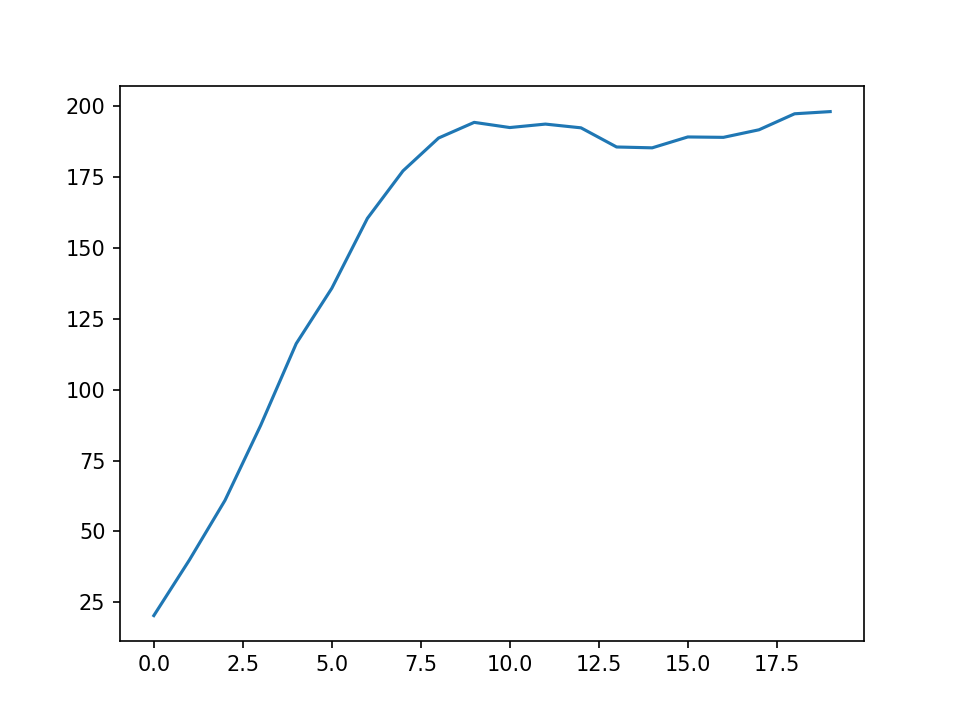

In [25]:
df_trials['episode_reward_mean'].plot()

### Exercise:
Look at same with tensorboard. In a console, start tensorboard with: `tensorboard --logdir=~/ray_results`

In [26]:
! pip install tensorboard

In [27]:
! tensorboard --logdir=~/ray_results # Kernel -> interupt to stop

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.1.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


### More details on tune
* https://github.com/ray-project/ray/tree/master/rllib/tuned_examples list essentially yaml that can be used with the command line interface for tune
* we will use tune to run of the a3c examples (this is a cpu only regression test)

In [28]:
! pip install pyyaml # install package to read yamls, import with yaml

In [29]:
import yaml
import urllib

In [30]:
# grab an a3c example from github
link = "https://raw.githubusercontent.com/ray-project/ray/master/rllib/tuned_examples/pong-a3c.yaml"
f = urllib.request.urlopen(link)
yaml_example = f.read()
print(yaml_example)

b'# This gets to ~19-20 reward in ~30 minutes / 4m steps on a m4.10xl instance\n# TODO(rliaw): this has regressed in performance\npong-a3c:\n    env: PongDeterministic-v4\n    run: A3C\n    config:\n        num_workers: 16\n        sample_batch_size: 20\n        use_pytorch: false\n        vf_loss_coeff: 0.5\n        entropy_coeff: 0.01\n        gamma: 0.99\n        grad_clip: 40.0\n        lambda: 1.0\n        lr: 0.0001\n        observation_filter: NoFilter\n        preprocessor_pref: rllib\n        model:\n            use_lstm: true\n            conv_activation: elu\n            dim: 42\n            grayscale: true\n            zero_mean: false\n            # Reduced channel depth and kernel size from default\n            conv_filters: [\n                [32, [3, 3], 2],\n                [32, [3, 3], 2],\n                [32, [3, 3], 2],\n                [32, [3, 3], 2],\n            ]\n'


In [31]:
tune_config_example = yaml.safe_load(yaml_example)
print(tune_config_example)

{'pong-a3c': {'env': 'PongDeterministic-v4', 'run': 'A3C', 'config': {'num_workers': 16, 'sample_batch_size': 20, 'use_pytorch': False, 'vf_loss_coeff': 0.5, 'entropy_coeff': 0.01, 'gamma': 0.99, 'grad_clip': 40.0, 'lambda': 1.0, 'lr': 0.0001, 'observation_filter': 'NoFilter', 'preprocessor_pref': 'rllib', 'model': {'use_lstm': True, 'conv_activation': 'elu', 'dim': 42, 'grayscale': True, 'zero_mean': False, 'conv_filters': [[32, [3, 3], 2], [32, [3, 3], 2], [32, [3, 3], 2], [32, [3, 3], 2]]}}}}


In [32]:
tune_config_example["pong-a3c"]["config"]["num_workers"]=2
tune_config_example["pong-a3c"]["stop"] = {"training_iteration": 10}
print(tune_config_example)

{'pong-a3c': {'env': 'PongDeterministic-v4', 'run': 'A3C', 'config': {'num_workers': 2, 'sample_batch_size': 20, 'use_pytorch': False, 'vf_loss_coeff': 0.5, 'entropy_coeff': 0.01, 'gamma': 0.99, 'grad_clip': 40.0, 'lambda': 1.0, 'lr': 0.0001, 'observation_filter': 'NoFilter', 'preprocessor_pref': 'rllib', 'model': {'use_lstm': True, 'conv_activation': 'elu', 'dim': 42, 'grayscale': True, 'zero_mean': False, 'conv_filters': [[32, [3, 3], 2], [32, [3, 3], 2], [32, [3, 3], 2], [32, [3, 3], 2]]}}, 'stop': {'training_iteration': 10}}}


In [33]:
ray.tune.run_experiments(tune_config_example)

Trial name,status,loc
A3C_PongDeterministic-v4_3e2a9e6c,RUNNING,


Result for A3C_PongDeterministic-v4_3e2a9e6c:
  custom_metrics: {}
  date: 2020-02-19_09-36-51
  done: false
  episode_len_mean: 912.5
  episode_reward_max: -19.0
  episode_reward_mean: -20.0
  episode_reward_min: -21.0
  episodes_this_iter: 2
  episodes_total: 2
  experiment_id: 54beb62abcdc4657b74edad1698f6e1c
  experiment_tag: '0'
  hostname: GDA-Oryx-Pro
  info:
    apply_time_ms: 2.223
    dispatch_time_ms: 6.654
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 7.24696159362793
      model: {}
      policy_entropy: 35.83011245727539
      policy_loss: 4.331221103668213
      var_gnorm: 25.906709671020508
      vf_explained_var: 0.1997147798538208
      vf_loss: 0.1984129250049591
    num_steps_sampled: 2000
    num_steps_trained: 2000
    wait_time_ms: 29.68
  iterations_since_restore: 1
  node_ip: 172.28.46.114
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 43.35833333333334
    ram_util_percent: 69.47500000000001
  pid: 3664
 

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_PongDeterministic-v4_3e2a9e6c,RUNNING,172.28.46.114:3664,1,7.66741,2000,-20


Result for A3C_PongDeterministic-v4_3e2a9e6c:
  custom_metrics: {}
  date: 2020-02-19_09-36-59
  done: false
  episode_len_mean: 908.8333333333334
  episode_reward_max: -19.0
  episode_reward_mean: -20.5
  episode_reward_min: -21.0
  episodes_this_iter: 4
  episodes_total: 6
  experiment_id: 54beb62abcdc4657b74edad1698f6e1c
  experiment_tag: '0'
  hostname: GDA-Oryx-Pro
  info:
    apply_time_ms: 1.76
    dispatch_time_ms: 6.459
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 6.016111850738525
      model: {}
      policy_entropy: 35.81016540527344
      policy_loss: 2.4332261085510254
      var_gnorm: 25.920637130737305
      vf_explained_var: 0.07311731576919556
      vf_loss: 0.8830671310424805
    num_steps_sampled: 6000
    num_steps_trained: 6000
    wait_time_ms: 26.98
  iterations_since_restore: 2
  node_ip: 172.28.46.114
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 57.38000000000001
    ram_util_percent: 74.14999999999999

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_PongDeterministic-v4_3e2a9e6c,RUNNING,172.28.46.114:3664,2,15.0298,6000,-20.5


Result for A3C_PongDeterministic-v4_3e2a9e6c:
  custom_metrics: {}
  date: 2020-02-19_09-37-06
  done: false
  episode_len_mean: 910.2
  episode_reward_max: -18.0
  episode_reward_mean: -20.3
  episode_reward_min: -21.0
  episodes_this_iter: 4
  episodes_total: 10
  experiment_id: 54beb62abcdc4657b74edad1698f6e1c
  experiment_tag: '0'
  hostname: GDA-Oryx-Pro
  info:
    apply_time_ms: 1.818
    dispatch_time_ms: 5.661
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 34.6235466003418
      model: {}
      policy_entropy: 35.81010055541992
      policy_loss: -16.878671646118164
      var_gnorm: 25.935413360595703
      vf_explained_var: 0.00190049409866333
      vf_loss: 3.505776882171631
    num_steps_sampled: 10000
    num_steps_trained: 10000
    wait_time_ms: 28.501
  iterations_since_restore: 3
  node_ip: 172.28.46.114
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 58.818181818181806
    ram_util_percent: 78.23636363636363
  pid:

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_PongDeterministic-v4_3e2a9e6c,RUNNING,172.28.46.114:3664,3,22.4835,10000,-20.3


Result for A3C_PongDeterministic-v4_3e2a9e6c:
  custom_metrics: {}
  date: 2020-02-19_09-37-14
  done: false
  episode_len_mean: 914.8571428571429
  episode_reward_max: -18.0
  episode_reward_mean: -20.214285714285715
  episode_reward_min: -21.0
  episodes_this_iter: 4
  episodes_total: 14
  experiment_id: 54beb62abcdc4657b74edad1698f6e1c
  experiment_tag: '0'
  hostname: GDA-Oryx-Pro
  info:
    apply_time_ms: 1.601
    dispatch_time_ms: 5.619
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 11.337822914123535
      model: {}
      policy_entropy: 35.78117370605469
      policy_loss: 7.077888488769531
      var_gnorm: 25.94244384765625
      vf_explained_var: -0.0035576820373535156
      vf_loss: 0.5164065361022949
    num_steps_sampled: 14000
    num_steps_trained: 14000
    wait_time_ms: 29.465
  iterations_since_restore: 4
  node_ip: 172.28.46.114
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 57.86
    ram_util_percent: 81.97999

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_PongDeterministic-v4_3e2a9e6c,RUNNING,172.28.46.114:3664,4,29.8894,14000,-20.2143


Result for A3C_PongDeterministic-v4_3e2a9e6c:
  custom_metrics: {}
  date: 2020-02-19_09-37-21
  done: false
  episode_len_mean: 941.4444444444445
  episode_reward_max: -17.0
  episode_reward_mean: -20.0
  episode_reward_min: -21.0
  episodes_this_iter: 4
  episodes_total: 18
  experiment_id: 54beb62abcdc4657b74edad1698f6e1c
  experiment_tag: '0'
  hostname: GDA-Oryx-Pro
  info:
    apply_time_ms: 1.835
    dispatch_time_ms: 5.759
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 31.120746612548828
      model: {}
      policy_entropy: 35.798919677734375
      policy_loss: -21.66126251220703
      var_gnorm: 25.9537296295166
      vf_explained_var: 0.0011073946952819824
      vf_loss: 4.724043846130371
    num_steps_sampled: 18000
    num_steps_trained: 18000
    wait_time_ms: 32.072
  iterations_since_restore: 5
  node_ip: 172.28.46.114
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 58.127272727272725
    ram_util_percent: 85.7363636

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_PongDeterministic-v4_3e2a9e6c,RUNNING,172.28.46.114:3664,5,37.3593,18000,-20


Result for A3C_PongDeterministic-v4_3e2a9e6c:
  custom_metrics: {}
  date: 2020-02-19_09-37-29
  done: false
  episode_len_mean: 939.9130434782609
  episode_reward_max: -17.0
  episode_reward_mean: -20.130434782608695
  episode_reward_min: -21.0
  episodes_this_iter: 5
  episodes_total: 23
  experiment_id: 54beb62abcdc4657b74edad1698f6e1c
  experiment_tag: '0'
  hostname: GDA-Oryx-Pro
  info:
    apply_time_ms: 1.715
    dispatch_time_ms: 5.959
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 25.576602935791016
      model: {}
      policy_entropy: 35.73836898803711
      policy_loss: 13.937331199645996
      var_gnorm: 25.97056007385254
      vf_explained_var: -1.0
      vf_loss: 8.338322639465332
    num_steps_sampled: 22000
    num_steps_trained: 22000
    wait_time_ms: 31.996
  iterations_since_restore: 6
  node_ip: 172.28.46.114
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 60.39090909090908
    ram_util_percent: 89.65454545454

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_PongDeterministic-v4_3e2a9e6c,RUNNING,172.28.46.114:3664,6,45.0289,22000,-20.1304


Result for A3C_PongDeterministic-v4_3e2a9e6c:
  custom_metrics: {}
  date: 2020-02-19_09-37-36
  done: false
  episode_len_mean: 936.8518518518518
  episode_reward_max: -17.0
  episode_reward_mean: -20.11111111111111
  episode_reward_min: -21.0
  episodes_this_iter: 4
  episodes_total: 27
  experiment_id: 54beb62abcdc4657b74edad1698f6e1c
  experiment_tag: '0'
  hostname: GDA-Oryx-Pro
  info:
    apply_time_ms: 1.731
    dispatch_time_ms: 5.311
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 26.289445877075195
      model: {}
      policy_entropy: 35.66576385498047
      policy_loss: -17.67900848388672
      var_gnorm: 25.984615325927734
      vf_explained_var: -0.0009288787841796875
      vf_loss: 3.3061037063598633
    num_steps_sampled: 26000
    num_steps_trained: 26000
    wait_time_ms: 28.894
  iterations_since_restore: 7
  node_ip: 172.28.46.114
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 58.5
    ram_util_percent: 92.42
  

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_PongDeterministic-v4_3e2a9e6c,RUNNING,172.28.46.114:3664,7,52.3517,26000,-20.1111


Result for A3C_PongDeterministic-v4_3e2a9e6c:
  custom_metrics: {}
  date: 2020-02-19_09-37-44
  done: false
  episode_len_mean: 925.96875
  episode_reward_max: -17.0
  episode_reward_mean: -20.1875
  episode_reward_min: -21.0
  episodes_this_iter: 5
  episodes_total: 32
  experiment_id: 54beb62abcdc4657b74edad1698f6e1c
  experiment_tag: '0'
  hostname: GDA-Oryx-Pro
  info:
    apply_time_ms: 1.632
    dispatch_time_ms: 5.142
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 19.018173217773438
      model: {}
      policy_entropy: 35.6431770324707
      policy_loss: -13.244327545166016
      var_gnorm: 26.01045799255371
      vf_explained_var: 0.004557967185974121
      vf_loss: 2.779055595397949
    num_steps_sampled: 30000
    num_steps_trained: 30000
    wait_time_ms: 31.09
  iterations_since_restore: 8
  node_ip: 172.28.46.114
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 58.281818181818174
    ram_util_percent: 93.35454545454544

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_PongDeterministic-v4_3e2a9e6c,RUNNING,172.28.46.114:3664,8,59.7825,30000,-20.1875


Result for A3C_PongDeterministic-v4_3e2a9e6c:
  custom_metrics: {}
  date: 2020-02-19_09-37-51
  done: false
  episode_len_mean: 923.5277777777778
  episode_reward_max: -17.0
  episode_reward_mean: -20.22222222222222
  episode_reward_min: -21.0
  episodes_this_iter: 4
  episodes_total: 36
  experiment_id: 54beb62abcdc4657b74edad1698f6e1c
  experiment_tag: '0'
  hostname: GDA-Oryx-Pro
  info:
    apply_time_ms: 2.064
    dispatch_time_ms: 5.899
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 15.261628150939941
      model: {}
      policy_entropy: 35.675636291503906
      policy_loss: -11.467920303344727
      var_gnorm: 26.029220581054688
      vf_explained_var: -0.0021181106567382812
      vf_loss: 2.4942545890808105
    num_steps_sampled: 34000
    num_steps_trained: 34000
    wait_time_ms: 29.434
  iterations_since_restore: 9
  node_ip: 172.28.46.114
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 57.790909090909096
    ram_util_p

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_PongDeterministic-v4_3e2a9e6c,RUNNING,172.28.46.114:3664,9,67.1639,34000,-20.2222


Result for A3C_PongDeterministic-v4_3e2a9e6c:
  custom_metrics: {}
  date: 2020-02-19_09-37-58
  done: true
  episode_len_mean: 921.4634146341464
  episode_reward_max: -17.0
  episode_reward_mean: -20.24390243902439
  episode_reward_min: -21.0
  episodes_this_iter: 5
  episodes_total: 41
  experiment_id: 54beb62abcdc4657b74edad1698f6e1c
  experiment_tag: '0'
  hostname: GDA-Oryx-Pro
  info:
    apply_time_ms: 1.693
    dispatch_time_ms: 6.183
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 10.376443862915039
      model: {}
      policy_entropy: 35.65896987915039
      policy_loss: 7.5474419593811035
      var_gnorm: 26.054658889770508
      vf_explained_var: 0.000353395938873291
      vf_loss: 0.576629102230072
    num_steps_sampled: 38000
    num_steps_trained: 38000
    wait_time_ms: 32.211
  iterations_since_restore: 10
  node_ip: 172.28.46.114
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 57.04
    ram_util_percent: 94.04
  pi

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_PongDeterministic-v4_3e2a9e6c,TERMINATED,,10,74.5328,38000,-20.2439


Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_PongDeterministic-v4_3e2a9e6c,TERMINATED,,10,74.5328,38000,-20.2439


[A3C_PongDeterministic-v4_3e2a9e6c]

# Getting status and stopping ray
* https://ray.readthedocs.io/en/latest/package-ref.html#ray-package-reference
* https://ray.readthedocs.io/en/latest/package-ref.html#ray.init

In [34]:
ray.is_initialized()

True

In [35]:
ray.nodes()

[{'NodeID': '711dc547e6d877e504533315f7e9f1d5a94c15c3',
  'Alive': True,
  'NodeManagerAddress': '172.28.46.114',
  'NodeManagerHostname': 'GDA-Oryx-Pro',
  'NodeManagerPort': 40631,
  'ObjectManagerPort': 37409,
  'ObjectStoreSocketName': '/tmp/ray/session_2020-02-19_09-11-14_660583_1683/sockets/plasma_store',
  'RayletSocketName': '/tmp/ray/session_2020-02-19_09-11-14_660583_1683/sockets/raylet',
  'Resources': {'node:172.28.46.114': 1.0,
   'CPU': 4.0,
   'memory': 97.0,
   'GPU': 1.0,
   'object_store_memory': 33.0},
  'alive': True}]

In [36]:
ray.cluster_resources()

{'node:172.28.46.114': 1.0,
 'CPU': 4.0,
 'memory': 97.0,
 'GPU': 1.0,
 'object_store_memory': 33.0}

In [37]:
ray.shutdown()

In [38]:
ray.is_initialized()

False